## STEP1 : Convert h5 file to pb file

```
python3 keras_to_freeze_binary.py ./bin/mobilenetv2_class20.h5 ./bin/mobilenetv2

```

## STEP2 : Convert pb file to xml, bin file

```
python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
        --framework tf \
        --input_model ./bin/mobilenetv2.pb \
        --batch 1 \
        --data_type FP32 \
        --output_dir bin/
```

## STEP3 : Inference with xml,bin file

tensorflow >=1.2
keras == 2.3.1
networkx ==2.3

https://www.dlology.com/blog/how-to-run-keras-model-inference-x3-times-faster-with-cpu-and-intel-openvino-1/

/home/intel/miniconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: from_ir() method of IENetwork is deprecated. Please use IENetwork class constructor to create valid IENetwork instance


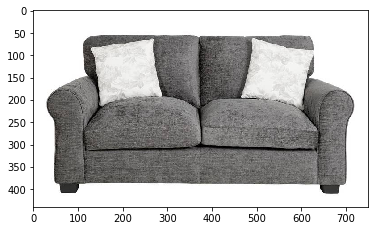

Predicted : SOFA (98.66%)


In [29]:
import os
# assert 'computer_vision_sdk' in os.environ['PYTHONPATH']

from PIL import Image
import numpy as np

try:
    from openvino import inference_engine as ie
    from openvino.inference_engine import IENetwork, IEPlugin
except Exception as e:
    exception_type = type(e).__name__
    print("The following error happened while importing Python API module:\n[ {} ] {}".format(exception_type, e))
    sys.exit(1)

def pre_process_image(imagePath, img_height=224):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    processedImg = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    processedImg = (np.array(processedImg) - 0) / 255.0

    # Change data layout from HWC to CHW
    processedImg = processedImg.transpose((2, 0, 1))
    processedImg = processedImg.reshape((n, c, h, w))

    return image, processedImg, imagePath

# Plugin initialization for specified device and load extensions library if specified.
plugin_dir = None
model_xml = './bin/mobilenetv2.xml'
model_bin = './bin/mobilenetv2.bin'



# Devices: GPU (intel), CPU, MYRIAD
# plugin = IEPlugin("MYRIAD", plugin_dirs=plugi)
plugin = IEPlugin("CPU")
# Read IRn_dir
net = IENetwork.from_ir(model=model_xml, weights=model_bin)
assert len(net.inputs.keys()) == 1
assert len(net.outputs) == 1
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
# Load network to the plugin
exec_net = plugin.load(network=net)
del net

# Run inference
fileName = './img/test/sofa.jpg'

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
plt.imshow(load_img(fileName))
plt.show()

image, processedImg, imagePath = pre_process_image(fileName)
res = exec_net.infer(inputs={input_blob: processedImg})
# Access the results and get the index of the highest confidence score
output_node_name = list(res.keys())[0]
res = res[output_node_name]

# Predicted class index.
idx = np.argsort(res[0])[-1]

# decode the predictions
import pickle
with open('./bin/class20.pickle', 'rb') as f:
    r = pickle.load(f) 
print('Predicted : {} ({:.2f}%)'.format(r[idx].upper(),res[0][idx]*100))